# Sun data
Analyze data from tracking the sun over a specific duration of time.

In [1]:
import ugradio
import ugradio.coord
import astropy.coordinates
import astropy.time
import time
import numpy as np
import matplotlib.pylab as plt
import inspect
import collections
from scipy.interpolate import interp1d
import glob
# import emcee

## Read in data

In [2]:
# pwd = '/home/zoeko/astro121lab/lab3/data/sun/full_day_sun_740am/'
pwd = '/home/pi/Blueberry Pi/astro121lab/lab3/data/sun/full_day_sun_740am/'

def freq_to_period(freq):
    '''take frequency (in kHz)
    and converts to period (in microseconds)'''
    return (1/freq) * 1000

freq = 500 * 1000 * 1000 # Hz

In [3]:
all_corrs = []
all_acc_cnts = []
all_times = []

num_files = len(glob.glob(f'{pwd}sun*'))

for i in np.arange(num_files):
    fname = f'{pwd}sun_{i}.npy'
    data = np.load(fname, allow_pickle=True).tolist()
    all_corrs += [list(data['corr01'])]
    all_acc_cnts += [data['acc_cnt']]
    all_times += [data['time']]
    
real_all_corrs = np.array(all_corrs).real

In [4]:
total_duration = (all_times[-1]-all_times[0])/60
print(total_duration)

12.985737844308217


In [5]:
# for i in range(len(data)):
#     data_block = data[i]
#     corr = data_block['corr01'].real
#     data_time = data_block['time']
# #     time = np.arange(len(corr)) * freq_to_period(freq/10**3) # in microseconds
#     plt.plot(corr)
#     plt.xlabel('Time [microseconds]')
#     plt.ylabel('Correlation')
# plt.show()

In [6]:
# # plot one block of data (waveform)
# plt.figure()
# plt.plot(corr)
# plt.title('Single Block Correlation')
# plt.xlabel('Time delay')
# plt.ylabel('Correlation')
# plt.show()

# f = np.fft.fftshift(np.fft.fftfreq(1024, 1/freq))
# Fx = np.fft.fftshift(np.fft.fft(corr))
# pwr = np.abs(Fx)**2

# # plot one block of data (FT)
# plt.figure()
# plt.plot(f/10**6, Fx)
# plt.title('Single Block Fourier Transform')
# plt.xlabel('Frequency [MHz]')
# plt.ylabel('FT')
# plt.show()

# # plot one block of data (power)
# plt.figure()
# plt.plot(f/10**6, pwr)
# plt.title('Single Block Fourier Transform Power Spectrum')
# plt.xlabel('Frequency [MHz]')
# plt.ylabel('Power')
# plt.show()

### Combine data into a 2-D array

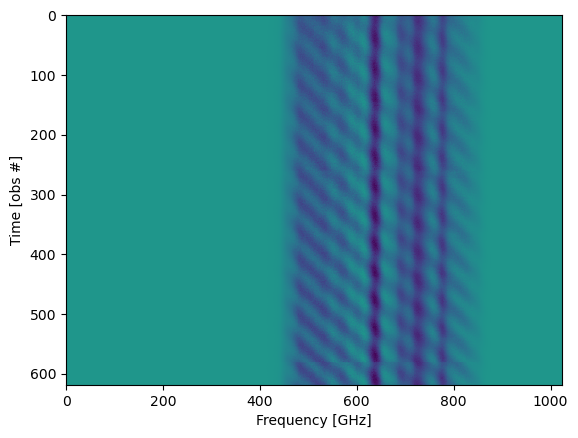

In [7]:
# plot raw data in 2d where x and y are frequency and time and z is power
# %matplotlib notebook
plt.figure()
plt.imshow(real_all_corrs, aspect='auto', interpolation='nearest')
plt.ylabel('Time [obs #]')
plt.xlabel('Frequency [GHz]')
plt.show()

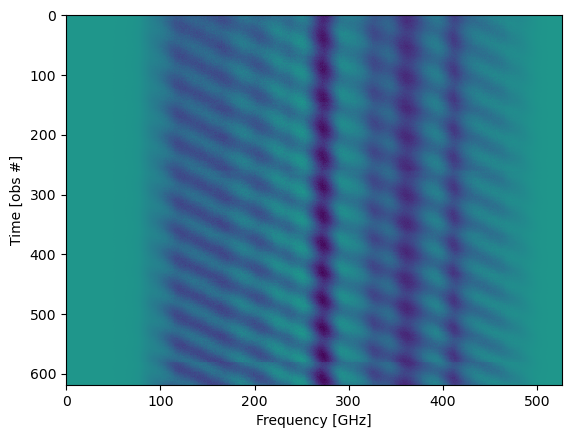

In [8]:
# remove data that has null values
    
nonzero_inds = np.where(real_all_corrs[0]!=0)[0]
nonzero_all_corrs = real_all_corrs[:, nonzero_inds]

plt.figure()
plt.imshow(nonzero_all_corrs, aspect='auto', interpolation='nearest')
plt.ylabel('Time [obs #]')
plt.xlabel('Frequency [GHz]')
plt.show()

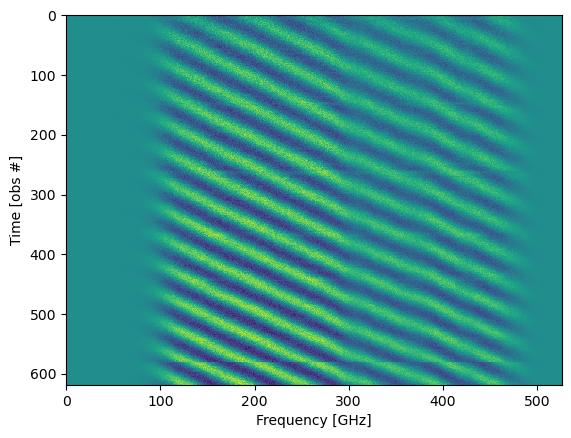

In [9]:
# normalize data by averaging out vertically and subtracting out that average
    
avg = np.average(nonzero_all_corrs, axis=0)
norm_all_corrs = nonzero_all_corrs - avg

plt.figure()
plt.imshow(norm_all_corrs, aspect='auto', interpolation='nearest')
plt.ylabel('Time [obs #]')
plt.xlabel('Frequency [GHz]')
plt.show()

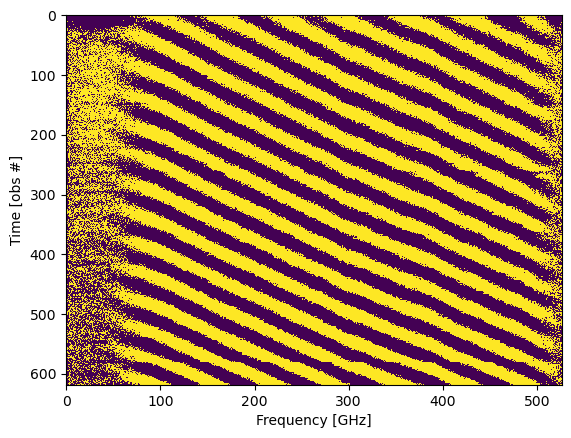

In [10]:
# np.angles shows the angle between the real and imaginary components (phase)
# should be able to see the fringes moving across - slopes
    
plt.figure()
plt.imshow(np.angle(norm_all_corrs), aspect='auto', interpolation='nearest')
plt.ylabel('Time [obs #]')
plt.xlabel('Frequency [GHz]')
plt.show()

### Look at 1-D data

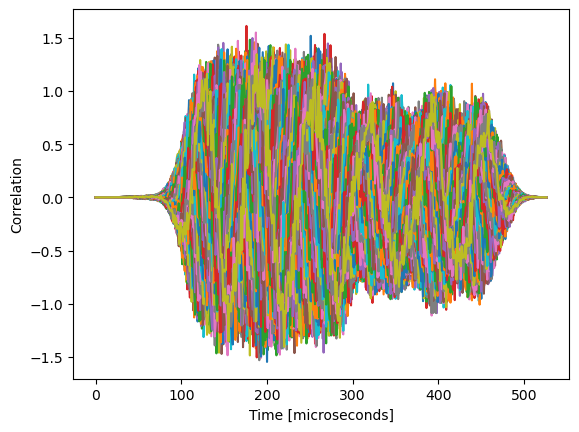

In [11]:
for i in range(len(norm_all_corrs)):
    corr = norm_all_corrs[i]
#     data_time = data_block['time']
#     time = np.arange(len(corr)) * freq_to_period(freq/10**3) # in microseconds
    plt.plot(corr)
    plt.xlabel('Time [microseconds]')
    plt.ylabel('Correlation')
plt.show()

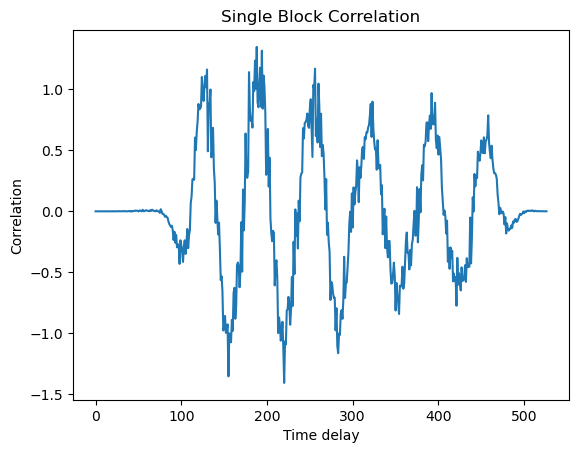

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


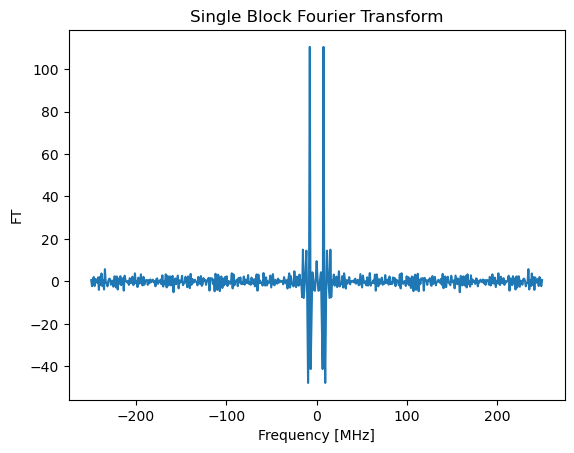

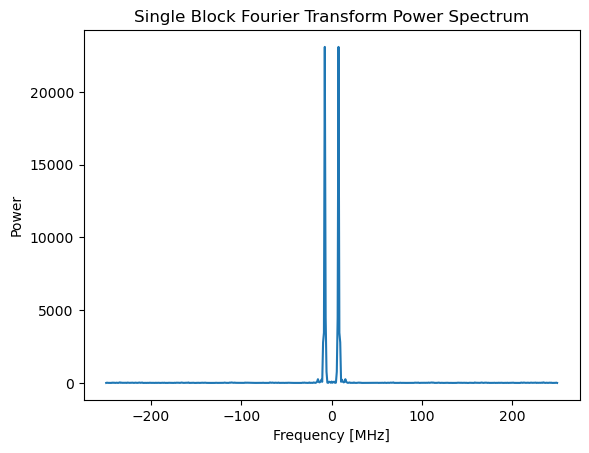

In [12]:
# plot one block of data (waveform)
plt.figure()
plt.plot(corr)
plt.title('Single Block Correlation')
plt.xlabel('Time delay')
plt.ylabel('Correlation')
plt.show()

f = np.fft.fftshift(np.fft.fftfreq(np.shape(norm_all_corrs)[1], 1/freq))
Fx = np.fft.fftshift(np.fft.fft(corr))
pwr = np.abs(Fx)**2

# plot one block of data (FT)
plt.figure()
plt.plot(f/10**6, Fx)
plt.title('Single Block Fourier Transform')
plt.xlabel('Frequency [MHz]')
plt.ylabel('FT')
plt.show()

# plot one block of data (power)
plt.figure()
plt.plot(f/10**6, pwr)
plt.title('Single Block Fourier Transform Power Spectrum')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Power')
plt.show()

### Explore phase shift in data

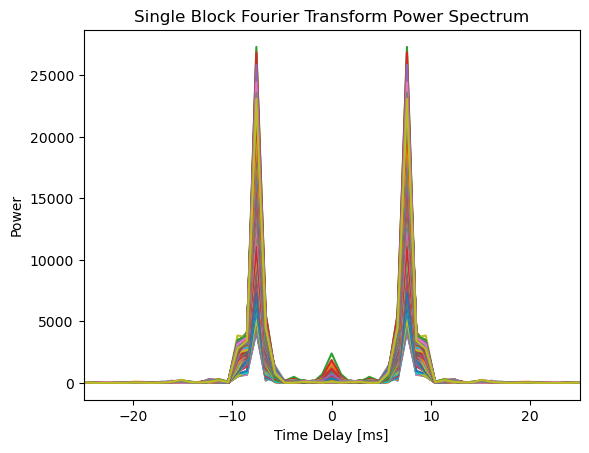

In [13]:
# %matplotlib notebook
for i in range(len(norm_all_corrs)):
    corr = norm_all_corrs[i]
#     data_time = data_block['time']
#     time = np.arange(len(corr)) * freq_to_period(freq/10**3) # in microseconds

    f = np.fft.fftshift(np.fft.fftfreq(np.shape(norm_all_corrs)[1], 1/freq))
    Fx = np.fft.fftshift(np.fft.fft(corr))
    pwr = np.abs(Fx)**2

    # plot one block of data (power)
    plt.plot(f/10**6, pwr)

plt.title('Single Block Fourier Transform Power Spectrum')
plt.xlabel('Time Delay [ms]')
plt.ylabel('Power')
plt.xlim(-25, 25)
plt.show()

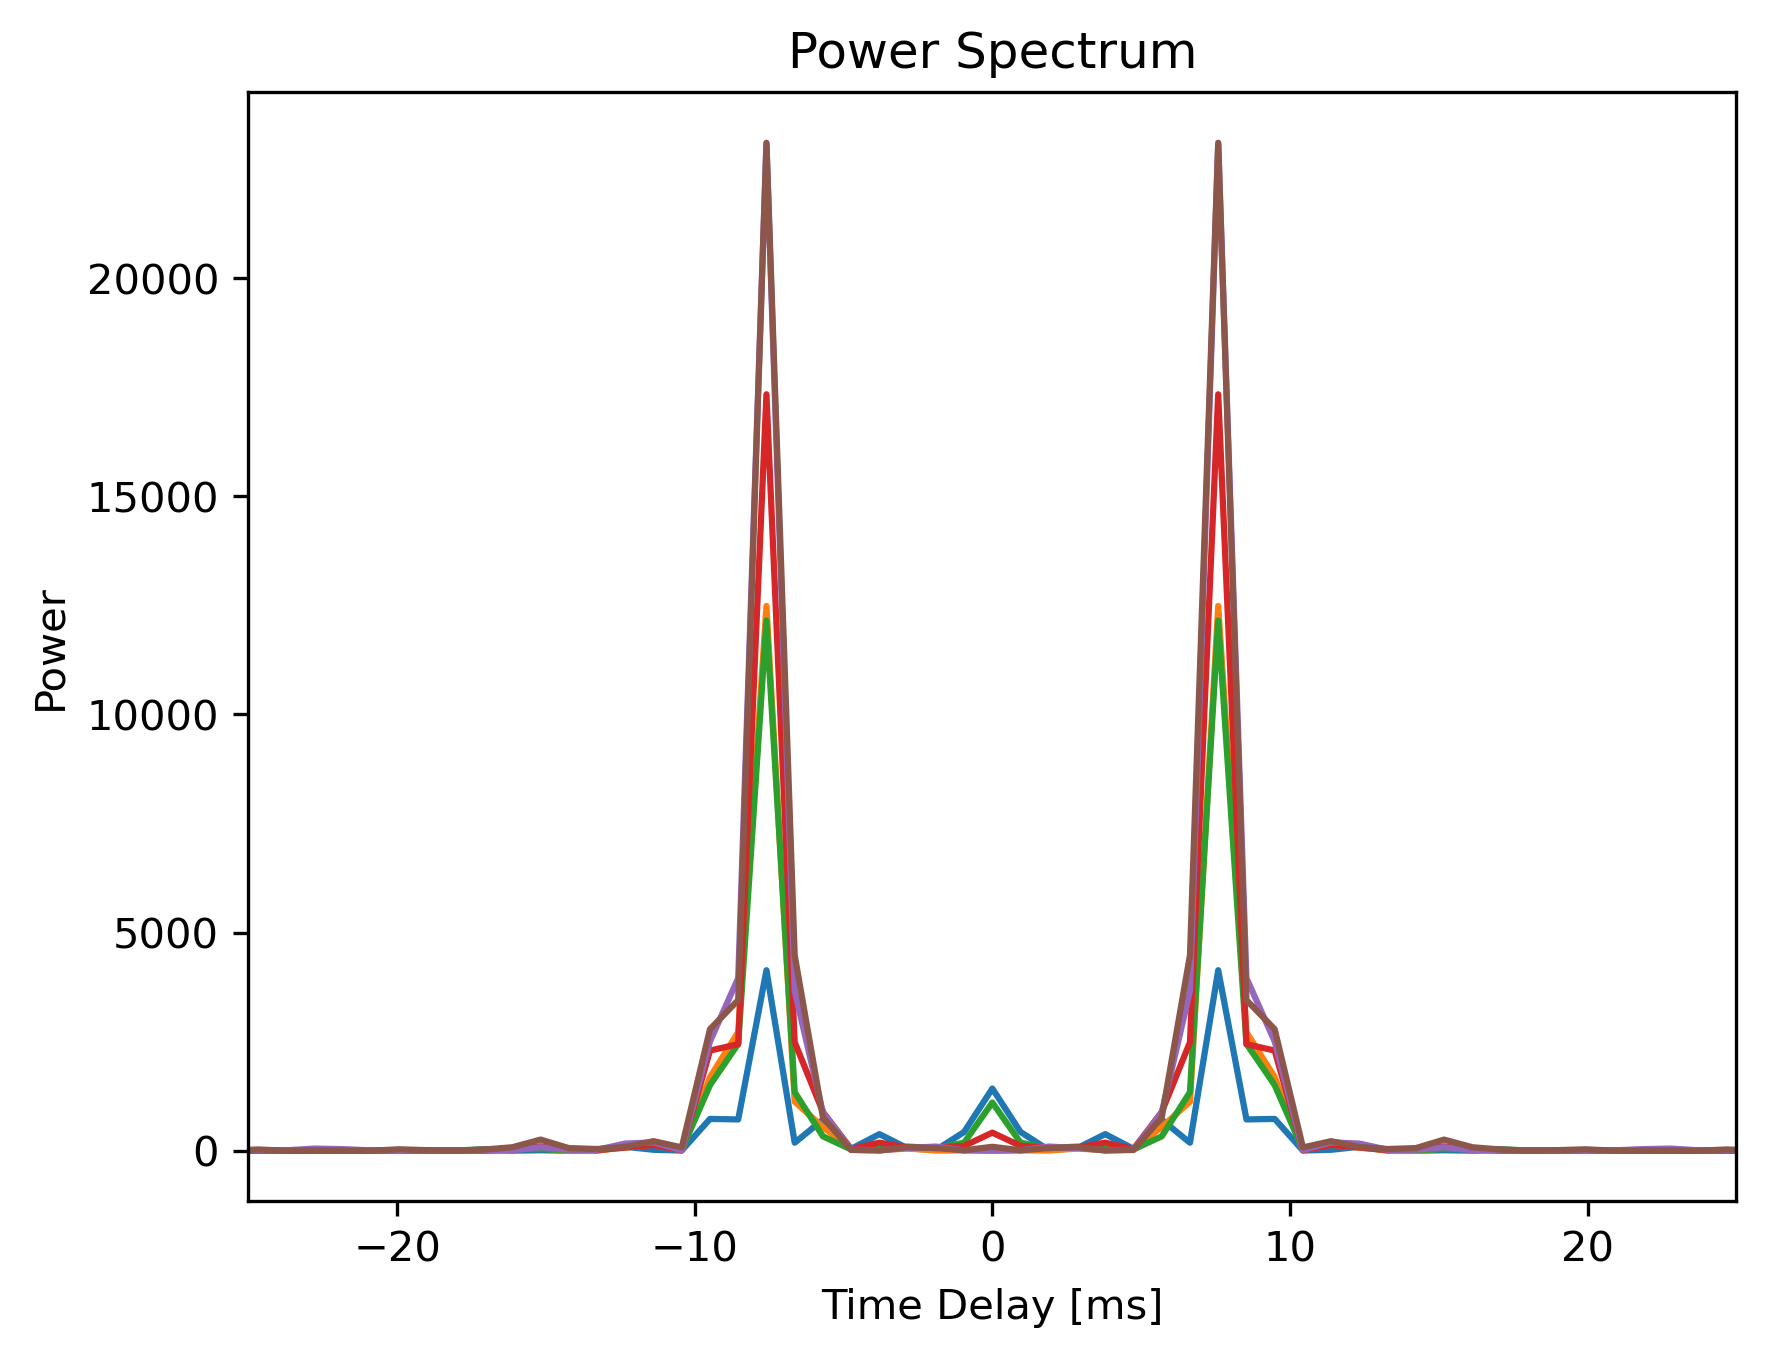

In [14]:
data_block_0 = norm_all_corrs[0]
# data_time_0 = data_block_0['time']

plt.figure(dpi=300)

t=0
for i in np.linspace(0, len(norm_all_corrs)-1, 6).astype(int):
    corr = norm_all_corrs[i]
#     data_time = data_block['time']
#     time = np.arange(len(corr)) * freq_to_period(freq/10**3) # in microseconds

    f = np.fft.fftshift(np.fft.fftfreq(np.shape(norm_all_corrs)[1], 1/freq))
    Fx = np.fft.fftshift(np.fft.fft(corr))
    pwr = np.abs(Fx)**2

    # plot one block of data (power)
#     time_elapsed = int((data_time-data_time_0)/60)
    plt.plot(f/10**6, pwr)
    t+=1

# plt.legend()
plt.title('Power Spectrum')
plt.xlabel('Time Delay [ms]')
plt.ylabel('Power')
plt.xlim(-25, 25)
plt.show()

In [15]:
# plot one channel of frequency to get power vs time, should be bessel function 

In [16]:
# plot time delay as a function of time